In [1]:
!pwd

/Users/ray/Downloads


In [22]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import random
from scipy.stats import gaussian_kde  
from matplotlib.lines import Line2D

In [54]:
# Functions to read and write xyz files

def read_xyz(filename):
    """Read XYZ file and return atom names and coordinates.
    
    Args:
        filename (str): Name of the XYZ file.
        
    Returns:
        atom_names (list): List of element symbols.
        coords (list): List of coordinates for every frame.
    """
    coords = []
    with open(filename, 'r') as f:
        while True:
            try:
                natm = int(f.readline().strip())  # Read number of atoms
                comment = f.readline()  # Skip comment line
                atom_names = []
                frame = []
                for _ in range(natm):
                    parts = f.readline().split()
                    atom_names.append(parts[0])
                    frame.append([float(parts[1]), float(parts[2]), float(parts[3])])
                coords.append(frame)
            except Exception as e:
                # End of file or format error
                break
    return atom_names, coords


def write_xyz(filename, atoms, coords):
    """Write atom names and coordinate data to an XYZ file.
    
    Args:
        filename (str): Name of the output XYZ file.
        atoms (iterable): List of atom names.
        coords (list): Coordinates (list of frames, each frame is a list of atom positions).
    """
    natoms = len(atoms)
    with open(filename, 'w') as f:
        for i, frame in enumerate(coords):
            f.write(f"{natoms}\n")
            f.write(f"Frame {i}\n")
            for a, pos in zip(atoms, frame): 
                f.write(" {:3} {:21.12f} {:21.12f} {:21.12f}\n".format(a, *pos))


In [ ]:
# Define folder paths for each simulation.
# If you have only one dataset, simply define one key.
folders = {
    # Uncomment or add additional datasets as needed:
     "M1": "./dbba_data/mlip/m1_o",
     "M2": "./dbba_data/mlip/m1_m",
    # "seed2_300": "./training/slab1_seed2/300",
    # "seed2_450": "./training/slab1_seed2/450",
    # "seed3_300": "./training/slab1_seed3/300",
    # "seed3_450": "./training/slab1_seed3/450",
}

# Load the model deviation data from each folder into a dictionary.
data_dict = {}
for key, folder in folders.items():
    file_path = os.path.join(folder, "model_devi.out")
    data = np.loadtxt(file_path)
    data_dict[key] = data
    n_points = len(data)
    sim_time = n_points * 0.00025 * 40
    print(f"{key}: {n_points} data points, simulation time = {sim_time:.2f}")


M1: 9879 data points, simulation time = 98.79
M2: 8001 data points, simulation time = 80.01


In [92]:
# Read trajectories from dump.xyz files and store them in dictionaries.
atoms_dict = {}
coords_dict = {}

for key, folder in folders.items():
    xyz_file = os.path.join(folder, "dump.xyz")
    print(f"Reading {xyz_file} ...")
    atoms, coords = read_xyz(xyz_file)
    atoms_dict[key] = atoms
    coords_dict[key] = coords
    print(f"Finished reading {xyz_file}")


Reading ./dbba_data/mlip/m1_o/dump.xyz ...
Finished reading ./dbba_data/mlip/m1_o/dump.xyz
Reading ./dbba_data/mlip/m1_m/dump.xyz ...
Finished reading ./dbba_data/mlip/m1_m/dump.xyz


M1: n=9879, Mean=1.2092, Median=1.2086, Std=0.0123, Min=1.1684, Max=1.2577
M2: n=8001, Mean=1.2082, Median=1.2080, Std=0.0091, Min=1.1801, Max=1.2444


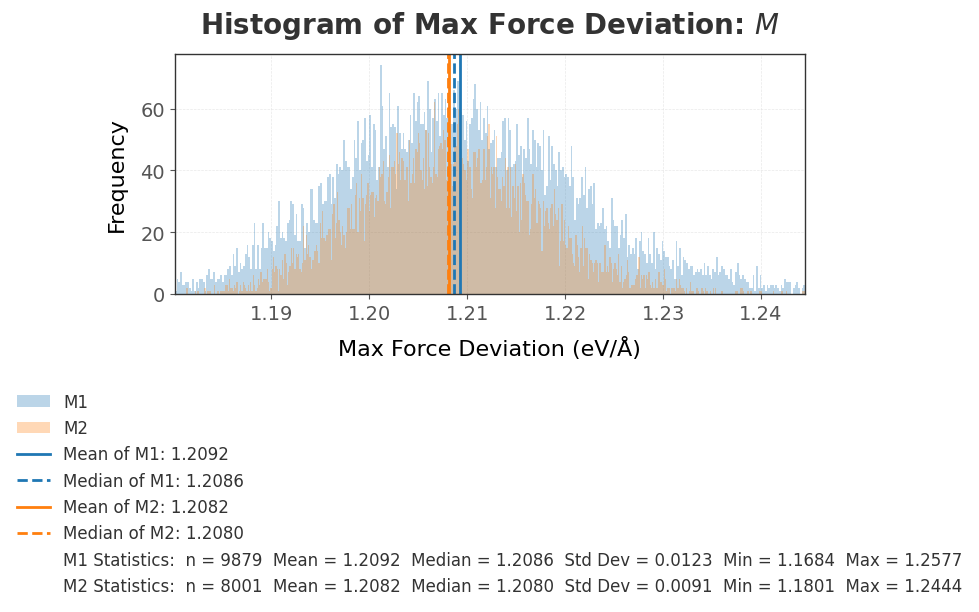

Updated plot with automatic x-limits and enhanced legend including number of datapoints.


In [ ]:
plt.rcParams.update({
    'figure.figsize': (9, 6),
    'figure.dpi': 100,
    'axes.titlesize': 20,
    'axes.titleweight': 'semibold',
    'axes.titlepad': 15,
    'axes.labelsize': 16,
    'axes.labelweight': 'medium',
    'axes.labelpad': 10,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'xtick.color': '#555555',
    'ytick.color': '#555555',
    'grid.color': '#E0E0E0',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1,
    'legend.fontsize': 12,
    'legend.frameon': False,
    'font.family': 'sans-serif',
    'font.sans-serif': ['IBM Plex Sans', 'Lato', 'DejaVu Sans'],
    'text.color': '#333333'
})

# Compute maximum force deviation (assumed to be in column index 4) for each dataset.
mf_dict = {}
stats_dict = {}  # Store all statistics for each dataset

for key, data in data_dict.items():
    mf = data[:, 4] # change this depending on what quantity you want to plot
    mf_dict[key] = mf
    
    # Calculate all statistics
    stats_dict[key] = {
        'mean': np.mean(mf),
        'median': np.median(mf),
        'std': np.std(mf),
        'min': np.min(mf),
        'max': np.max(mf),
        'count': len(mf)  # Add count of datapoints
    }
    
    print(f"{key}: n={stats_dict[key]['count']}, Mean={stats_dict[key]['mean']:.4f}, "
          f"Median={stats_dict[key]['median']:.4f}, Std={stats_dict[key]['std']:.4f}, "
          f"Min={stats_dict[key]['min']:.4f}, Max={stats_dict[key]['max']:.4f}")

# Auto-generate colors using a colormap.
nbins = 500
cmap = plt.get_cmap("tab10")
keys_sorted = sorted(folders.keys())  # Ensure consistent ordering
colors = {key: cmap(i % 10) for i, key in enumerate(keys_sorted)}
labels = {key: key for key in keys_sorted}

# Calculate the 5th and 95th percentiles across all datasets for automatic x-limits
all_data = np.concatenate([mf_dict[key] for key in keys_sorted])
x_lower = np.percentile(all_data, 5)
x_upper = np.percentile(all_data, 95)

# Create histogram plot using publication-quality settings
fig, ax = plt.subplots()

# Plot histograms
for key in keys_sorted:
    ax.hist(mf_dict[key], bins=nbins, color=colors[key], alpha=0.3, label=f"{labels[key]}")

# Create legend texts with all statistics
legend_texts = []
for key in keys_sorted:
    s = stats_dict[key]
    legend_text = (f"{key} Statistics:\
"
                  f"  n = {s['count']}\
"
                  f"  Mean = {s['mean']:.4f}\
"
                  f"  Median = {s['median']:.4f}\
"
                  f"  Std Dev = {s['std']:.4f}\
"
                  f"  Min = {s['min']:.4f}\
"
                  f"  Max = {s['max']:.4f}")
    legend_texts.append(legend_text)

# Add vertical lines for means (solid line) and medians (dashed line)
for key in keys_sorted:
    s = stats_dict[key]
    # mean
    ax.axvline(x=s['mean'], color=colors[key], linestyle='-', linewidth=2,
               label=f"Mean of {labels[key]}: {s['mean']:.4f}")
    # median
    ax.axvline(x=s['median'], color=colors[key], linestyle='--', linewidth=2,
               label=f"Median of {labels[key]}: {s['median']:.4f}")

ax.set_title('Histogram of Max Force Deviation: $M$', pad=15)
ax.set_xlabel('Max Force Deviation (eV/Å)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Ensure the plot is below the grid lines
ax.set_axisbelow(True)

# Set spines
for spine in ax.spines.values():
    spine.set_edgecolor('#333333')
    spine.set_linewidth(1)

# Ensure the ticks are set properly
ax.tick_params(axis='both', labelsize=14, colors='#555555')

# Set x-limits automatically based on computed percentiles
ax.set_xlim(s['min'], s['max'])

# Combine legend info: first the vertical lines then add our custom stats text as an extra legend entry
line_handles, line_labels = ax.get_legend_handles_labels()
# Create an extra legend entry that consolidates the dataset stats
extra_handles = [Line2D([0], [0], color='none', label=text) for text in legend_texts]
# Show all in two separate sections using ncol=1
ax.legend(handles=line_handles + extra_handles, loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=1)

# Adjust layout margins to accommodate the larger legend
plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.45)

plt.show()

print("Updated plot with automatic x-limits and enhanced legend including number of datapoints.")

In [77]:
# Choose ONE dataset for interval analysis.
# For instance, if you have only one dataset this automatically picks that one.
hist_key = keys_sorted[0]
mf_selected = mf_dict[hist_key]

# Optionally, compute a characteristic value (e.g., sigma_max) from the histogram.
counts, bin_edges = np.histogram(mf_selected, bins=nbins)
max_index = np.argmax(counts)
sigma_max = bin_edges[max_index]
print(f"{hist_key}: sigma_max = {sigma_max:.4f} eV/Å")

# Define intervals (modify these as needed for your application).
interval_1 = [0.28, 0.31]
interval_2 = [0.31, 0.34]
interval_3 = [0.34, 0.35]

# For the dataset selected in cell 5 (hist_key), get indices falling in each interval.
int1_geom = []
int2_geom = []
int3_geom = []

for i, mf_val in enumerate(mf_selected):
    if interval_1[0] <= mf_val < interval_1[1]:
        int1_geom.append(i)
    elif interval_2[0] <= mf_val < interval_2[1]:
        int2_geom.append(i)
    elif interval_3[0] <= mf_val < interval_3[1]:
        int3_geom.append(i)

print(f"Interval {interval_1}: {len(int1_geom)} configurations, {(len(int1_geom)/len(mf_selected))*100:.2f}%")
print(f"Interval {interval_2}: {len(int2_geom)} configurations, {(len(int2_geom)/len(mf_selected))*100:.2f}%")
print(f"Interval {interval_3}: {len(int3_geom)} configurations, {(len(int3_geom)/len(mf_selected))*100:.2f}%")


R1: sigma_max = 0.2867 eV/Å
Interval [0.28, 0.31]: 253 configurations, 14.84%
Interval [0.31, 0.34]: 251 configurations, 14.72%
Interval [0.34, 0.35]: 81 configurations, 4.75%


In [30]:
# Specify the dataset key from which to extract configurations.
# If you have only one dataset, this will be that key.
extract_key = keys_sorted[1]  # or, for example: "my_unique_dataset"

# Define the number of samples to extract from each interval.
Nsample_int1 = 600 
Nsample_int2 = 600
Nsample_int3 = 675

# Ensure there are enough configurations in each interval.
if len(int1_geom) < Nsample_int1 or len(int2_geom) < Nsample_int2 or len(int3_geom) < Nsample_int3:
    raise ValueError("Not enough configurations in one of the intervals for the desired sampling.")

# Randomly select frame indices for each interval.
selected_int1 = sorted(random.sample(int1_geom, Nsample_int1))
selected_int2 = sorted(random.sample(int2_geom, Nsample_int2))
selected_int3 = sorted(random.sample(int3_geom, Nsample_int3))

# Define output file paths based on the extraction folder.
folder_extract = folders[extract_key]
output_log = os.path.join(folder_extract, "output_selected.log")
geom_file1 = os.path.join(folder_extract, "geom_int1.xyz")
geom_file2 = os.path.join(folder_extract, "geom_int2.xyz")
geom_file3 = os.path.join(folder_extract, "geom_int3.xyz")

# Write the output log using the corresponding model deviation data.
data_extract = data_dict[extract_key]
with open(output_log, 'w') as f:
    f.write("# Selected Frame 1 interval:\n#--------------------------\n")
    for idx in selected_int1:
        row_str = " ".join(map(str, data_extract[idx]))
        f.write(f"{idx} {row_str}\n")
    f.write("#--------------------------\n# Selected Frame 2 interval:\n#--------------------------\n")
    for idx in selected_int2:
        row_str = " ".join(map(str, data_extract[idx]))
        f.write(f"{idx} {row_str}\n")
    f.write("#--------------------------\n# Selected Frame 3 interval:\n#--------------------------\n")
    for idx in selected_int3:
        row_str = " ".join(map(str, data_extract[idx]))
        f.write(f"{idx} {row_str}\n")
print("Output log written to:", output_log)

# Extract coordinates and write xyz files for the selected frames.
coords_extract = coords_dict[extract_key]
atoms_extract = atoms_dict[extract_key]

selected_coords1 = [coords_extract[i] for i in selected_int1]
selected_coords2 = [coords_extract[i] for i in selected_int2]
selected_coords3 = [coords_extract[i] for i in selected_int3]

print("Writing", geom_file1)
write_xyz(geom_file1, atoms_extract, selected_coords1)
print("Writing", geom_file2)
write_xyz(geom_file2, atoms_extract, selected_coords2)
print("Writing", geom_file3)
write_xyz(geom_file3, atoms_extract, selected_coords3)


Output log written to: ./training/c1_seed1/output_selected.log
Writing ./training/c1_seed1/geom_int1.xyz
Writing ./training/c1_seed1/geom_int2.xyz
Writing ./training/c1_seed1/geom_int3.xyz
